In [125]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, regularizers, Sequential
from tensorflow.keras.callbacks import EarlyStopping

# Opcjonalnie Bayesian Optimization
import keras_tuner as kt

In [126]:
df = pd.read_csv('data/SuperMarket Analysis.csv')
df.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Sales,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,Alex,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,1:08:00 PM,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,Giza,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29:00 AM,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,Alex,Yangon,Normal,Female,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,1:23:00 PM,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,Alex,Yangon,Member,Female,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,8:33:00 PM,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,Alex,Yangon,Member,Female,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37:00 AM,Ewallet,604.17,4.761905,30.2085,5.3


In [127]:
df['UnitPriceLog'] = np.log1p(df['Unit price'])

df['Date'] = pd.to_datetime(df['Date'])
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Hour'] = pd.to_datetime(df['Time']).dt.hour
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

df.drop(['Date', 'Time', 'Invoice ID'], axis=1, inplace=True)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11924\1321478894.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Hour'] = pd.to_datetime(df['Time']).dt.hour


In [128]:
# df_encoded = pd.get_dummies(df, drop_first=True)
# df_encoded.head()

columns_to_encode = ['Branch', 'City', 'Customer type','Gender', 'Product line', 'Payment']

for col in columns_to_encode:
    unique_vals = df[col].unique()
    mapping = {val: i+1 for i, val in enumerate(unique_vals)}
    df[col + '_id'] = df[col].map(mapping)
df.drop(columns_to_encode, axis=1, inplace=True)



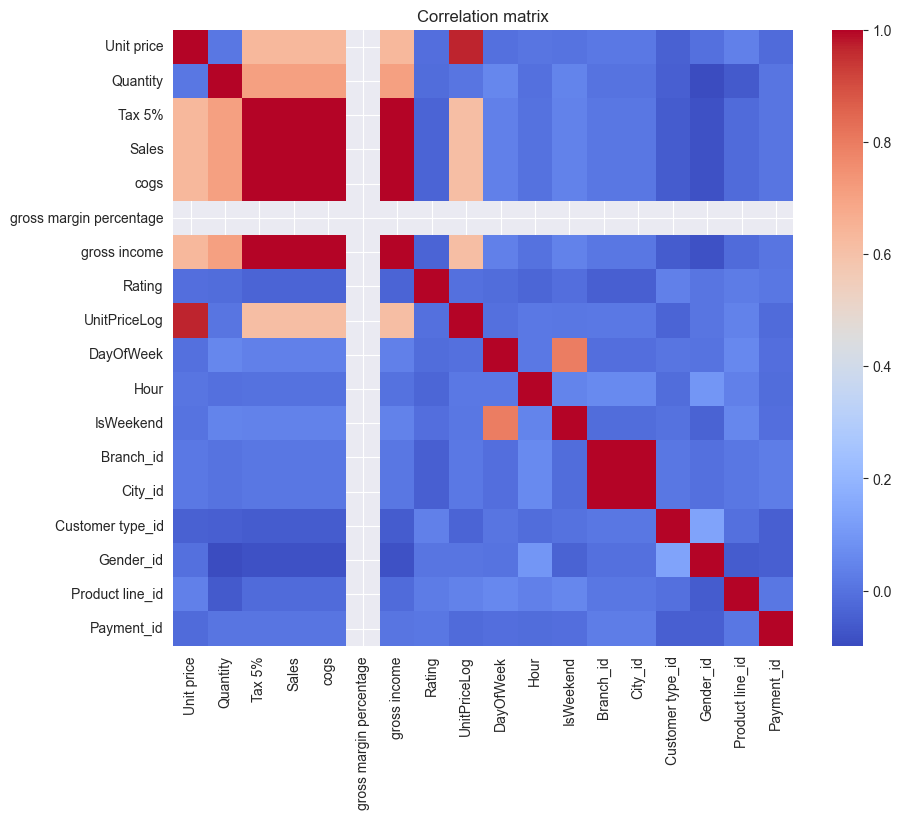

In [129]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title("Correlation matrix")
plt.show()

In [130]:
X = df.drop('UnitPriceLog', axis=1)
Y = df['UnitPriceLog']

In [131]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

In [132]:
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

Y_train_scaled = scaler_Y.fit_transform(Y_train.values.reshape(-1,1))
Y_test_scaled  = scaler_Y.transform(Y_test.values.reshape(-1,1))

In [133]:
#ewaluacja modelu
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error, max_error, explained_variance_score

def evaluate_model(model, X_train, X_test, Y_train, Y_test, scaler_Y=None):
    pred_train_scaled = model.predict(X_train).reshape(-1, 1)
    pred_test_scaled = model.predict(X_test).reshape(-1, 1)

    y_train = scaler_Y.inverse_transform(Y_train_scaled).reshape(-1)
    y_test = scaler_Y.inverse_transform(Y_test_scaled).reshape(-1)

    pred_train = scaler_Y.inverse_transform(pred_train_scaled).reshape(-1)
    pred_test = scaler_Y.inverse_transform(pred_test_scaled).reshape(-1)

    def mape(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true))

    def smape(y_true, y_pred):
        return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

    metrics = {
        "MAE" : mean_absolute_error(y_test, pred_test),
        "MSE" : mean_squared_error(y_test, pred_test),
        "RMSE" : np.sqrt(mean_squared_error(y_test, pred_test)),
        "R2" : r2_score(y_test, pred_test),
        "MedAE" : median_absolute_error(y_test, pred_test),
        "MaxError" : max_error(y_test, pred_test),
        "MAPE" : mape(y_test, pred_test),
        "SMAPE" : smape(y_test, pred_test),
        "ExplainedVar" : explained_variance_score(y_test, pred_test)
    }
    return metrics, pred_test

def plot_actual_vs_predict(y_test, y_pred):
    plt.figure(figsize=(8,5))
    plt.scatter(range(len(Y_actual)), y_test, label="Actual", alpha=0.6)
    plt.scatter(range(len(Y_pred)), y_pred, label="Prediction", alpha=0.6)
    plt.xlabel("Samples")
    plt.ylabel("Unit Price")
    plt.title("Prediction vs Actual")
    plt.legend()
    plt.show()

def plot_residuals(y_test, y_pred):
    residuals = y_test - y_pred
    plt.figure(figsize=(7,6))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(0, color="red")
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    plt.grid(True)
    plt.show()

def plot_learning_curve(history):
    plt.figure(figsize=(10,5))
    plt.title("Learning Curve")
    plt.plot(history.history['loss'], label="train loss")
    plt.plot(history.history['val_loss'], label="val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_error(y_test, y_pred):
    errors = y_test - y_pred
    plt.figure(figsize=(8,5))
    plt.hist(errors, bins=30, edgecolor='k', alpha=0.7)
    plt.xlabel("Prediction Error")
    plt.ylabel("Count")
    plt.title("Histogram of Prediction Errors")
    plt.show()

In [185]:
from keras_tuner.src.backend import keras


def build_model(input_dim):
        # model = Sequential()
        # # Warstwa ukryta 1
        # model.add(layers.Dense(96, activation='relu',
        #                        input_shape=(input_dim,),
        #                        kernel_regularizer=regularizers.l2(0.001)))
        # model.add(layers.BatchNormalization())
        # model.add(layers.Dropout(0.3))
        # 
        # # Warstwa ukryta 2
        # model.add(layers.Dense(96, activation='relu',
        #                        kernel_regularizer=regularizers.l2(0.001)))
        # model.add(layers.BatchNormalization())
        # model.add(layers.Dropout(0.3))
        # 
        # # Wyjście
        # model.add(layers.Dense(1, activation='linear'))
        # 
        # model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        # return model
        model = Sequential()

        # Warstwa 0
        model.add(layers.Dense(
            128, 
            activation='relu',
            input_shape=(input_dim,),
            kernel_regularizer=regularizers.l2(0.001)
        ))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.1))

        # Warstwa 1
        model.add(layers.Dense(
            96, 
            activation='relu',
            kernel_regularizer=regularizers.l2(0.001)
        ))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.01))

        # Wyjście
        model.add(layers.Dense(1, activation='linear'))

        # learning rate z Bayes results
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.01),
            loss='mse',
            metrics=['mae']
        )

        return model

# EarlyStopping
es = EarlyStopping(patience=15, restore_best_weights=True)

input_dim = X_train_scaled.shape[1]
model = build_model(input_dim)
# Trening
history = model.fit(
    X_train_scaled, Y_train_scaled,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[es]
)

Epoch 1/200


C:\Users\Lenovo\PycharmProjects\ssi\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.2284 - mae: 0.7269 - val_loss: 0.2218 - val_mae: 0.2042
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2714 - mae: 0.2561 - val_loss: 0.2200 - val_mae: 0.1886
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2078 - mae: 0.1718 - val_loss: 0.2205 - val_mae: 0.1908
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1803 - mae: 0.1252 - val_loss: 0.2064 - val_mae: 0.1801
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1694 - mae: 0.1161 - val_loss: 0.2035 - val_mae: 0.1849
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1614 - mae: 0.1154 - val_loss: 0.1845 - val_mae: 0.1688
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1515 - mae: 0.1072 - val_loss: 0.1726 - val_mae: 0.1625
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1419 - mae: 0.0943 - val_loss: 0.1636 - val_mae: 0.1558
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1370 - mae: 0.

In [186]:
Y_pred_scaled = model.predict(X_test_scaled).flatten()
Y_pred = np.expm1(scaler_Y.inverse_transform(Y_pred_scaled.reshape(-1,1))).flatten()
Y_actual = np.expm1(scaler_Y.inverse_transform(Y_test_scaled.reshape(-1,1))).flatten()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [171]:
wynikowa = pd.DataFrame(columns=['title','MAE','MSE','RMSE','R2'])

In [187]:
title = 'Bayesian parameters'
mae = mean_absolute_error(Y_actual, Y_pred)
mse = mean_squared_error(Y_actual, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_actual, Y_pred)
wynikowa.loc[len(wynikowa)] = [title, mae, mse, rmse, r2]
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2: {r2:.3f}")

MAE: 1.542
MSE: 3.878
RMSE: 1.969
R2: 0.995


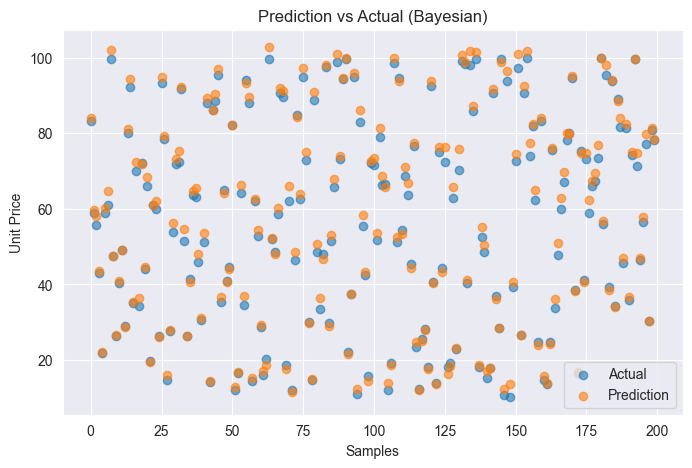

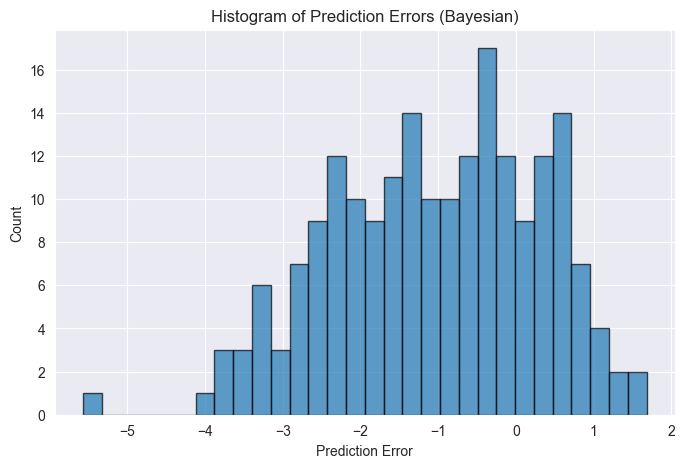

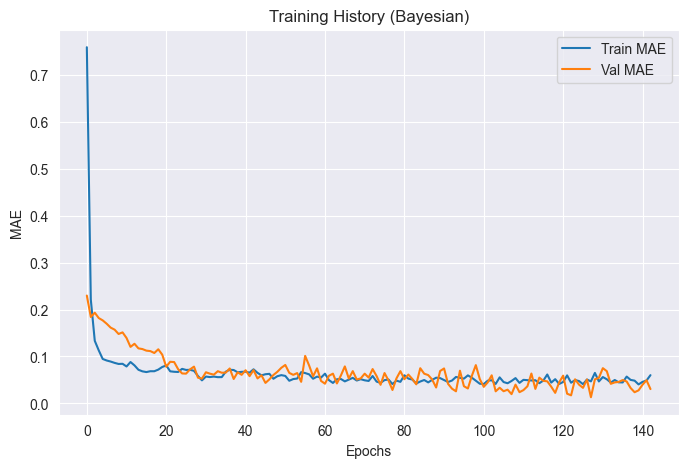

In [173]:
plt.figure(figsize=(8,5))
plt.scatter(range(len(Y_actual)), Y_actual, label="Actual", alpha=0.6)
plt.scatter(range(len(Y_pred)), Y_pred, label="Prediction", alpha=0.6)
plt.xlabel("Samples")
plt.ylabel("Unit Price")
plt.title("Prediction vs Actual (Bayesian)")
plt.legend()
plt.show()

errors = Y_actual - Y_pred
plt.figure(figsize=(8,5))
plt.hist(errors, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.title("Histogram of Prediction Errors (Bayesian)")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Training History (Bayesian)")
plt.legend()
plt.show()

In [174]:
def build_simple_model(input_dim):
    model = Sequential()
    model.add(layers.Dense(32, activation='relu', input_shape=(input_dim,)))
    model.add(layers.Dense(1, activation='linear'))

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

simple_model = build_simple_model(input_dim)
history_simple = simple_model.fit(
    X_train_scaled, Y_train_scaled,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
)

Epoch 1/200


C:\Users\Lenovo\PycharmProjects\ssi\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1024 - mae: 0.2612 - val_loss: 0.0926 - val_mae: 0.2477
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0746 - mae: 0.2216 - val_loss: 0.0786 - val_mae: 0.2290
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0569 - mae: 0.1924 - val_loss: 0.0597 - val_mae: 0.1995
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0440 - mae: 0.1682 - val_loss: 0.0472 - val_mae: 0.1757
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0336 - mae: 0.1453 - val_loss: 0.0364 - val_mae: 0.1536
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0259 - mae: 0.1259 - val_loss: 0.0287 - val_mae: 0.1362
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0202 - mae: 0.1094 - val_loss: 0.0230 - val_mae: 0.1207
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0161 - mae: 0.0978 - val_loss: 0.0187 - val_mae: 0.1090
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0133 - mae: 0.

In [175]:
Y_pred_scaled = simple_model.predict(X_test_scaled).flatten()
Y_pred = np.expm1(scaler_Y.inverse_transform(Y_pred_scaled.reshape(-1,1))).flatten()
Y_actual = np.expm1(scaler_Y.inverse_transform(Y_test_scaled.reshape(-1,1))).flatten()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


MAE: 1.627
MSE: 4.895
RMSE: 2.212
R2: 0.993


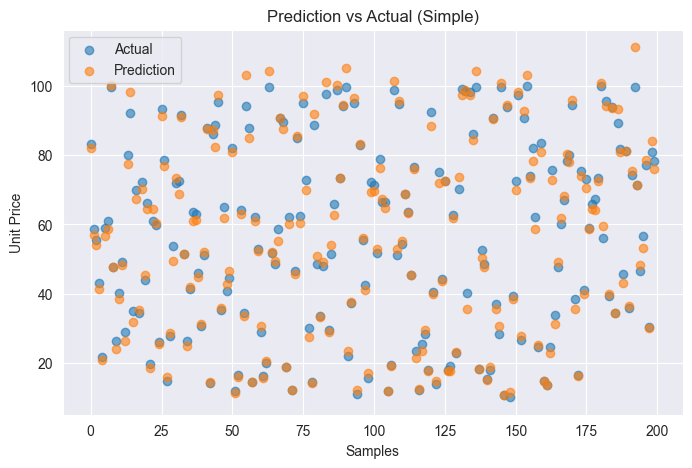

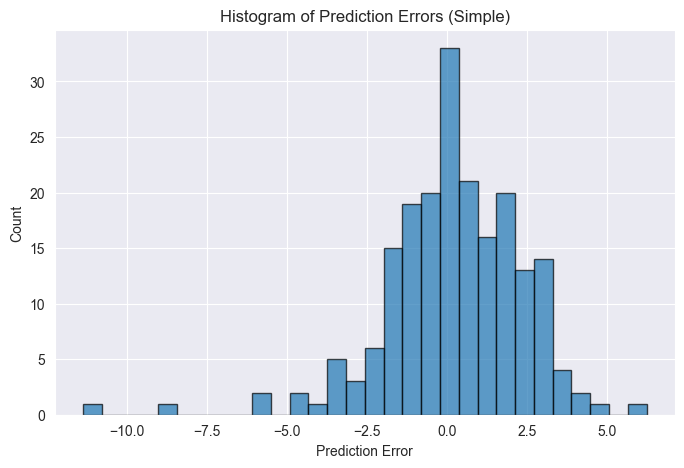

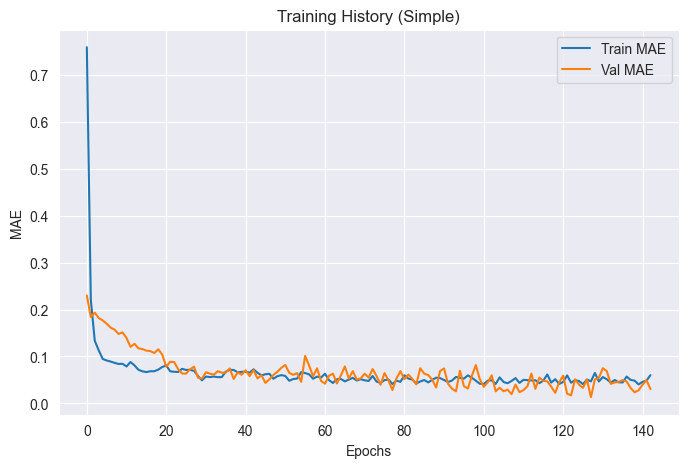

In [176]:
title='Simple'
mae = mean_absolute_error(Y_actual, Y_pred)
mse = mean_squared_error(Y_actual, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_actual, Y_pred)
wynikowa.loc[len(wynikowa)]=[title, mae, mse, rmse, r2]
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2: {r2:.3f}")
plt.figure(figsize=(8,5))
plt.scatter(range(len(Y_actual)), Y_actual, label="Actual", alpha=0.6)
plt.scatter(range(len(Y_pred)), Y_pred, label="Prediction", alpha=0.6)
plt.xlabel("Samples")
plt.ylabel("Unit Price")
plt.title("Prediction vs Actual (Simple)")
plt.legend()
plt.show()

errors = Y_actual - Y_pred
plt.figure(figsize=(8,5))
plt.hist(errors, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.title("Histogram of Prediction Errors (Simple)")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Training History (Simple)")
plt.legend()
plt.show()

In [177]:
def build_medium_model(input_dim):
    model = Sequential()

    model.add(layers.Dense(128, activation='relu', input_shape=(input_dim,)))

    model.add(layers.Dense(64, activation='relu'))

    model.add(layers.Dense(1, activation='linear'))

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

medium_model = build_medium_model(input_dim)
history_medium = medium_model.fit(
    X_train_scaled, Y_train_scaled,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    #callbacks=[es]
)

Epoch 1/200


C:\Users\Lenovo\PycharmProjects\ssi\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1134 - mae: 0.2661 - val_loss: 0.0385 - val_mae: 0.1588
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0318 - mae: 0.1432 - val_loss: 0.0224 - val_mae: 0.1228
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0132 - mae: 0.0898 - val_loss: 0.0107 - val_mae: 0.0827
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068 - mae: 0.0655 - val_loss: 0.0066 - val_mae: 0.0672
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - mae: 0.0568 - val_loss: 0.0053 - val_mae: 0.0609
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - mae: 0.0512 - val_loss: 0.0044 - val_mae: 0.0549
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - mae: 0.0459 - val_loss: 0.0040 - val_mae: 0.0511
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0410 - val_loss: 0.0031 - val_mae: 0.0448
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mae: 0.

In [178]:
Y_pred_scaled = medium_model.predict(X_test_scaled).flatten()
Y_pred = np.expm1(scaler_Y.inverse_transform(Y_pred_scaled.reshape(-1,1))).flatten()
Y_actual = np.expm1(scaler_Y.inverse_transform(Y_test_scaled.reshape(-1,1))).flatten()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


MAE: 2.373
MSE: 9.666
RMSE: 3.109
R2: 0.987


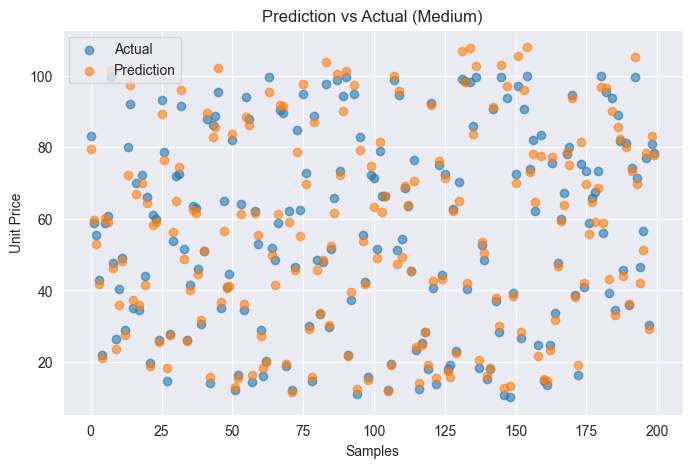

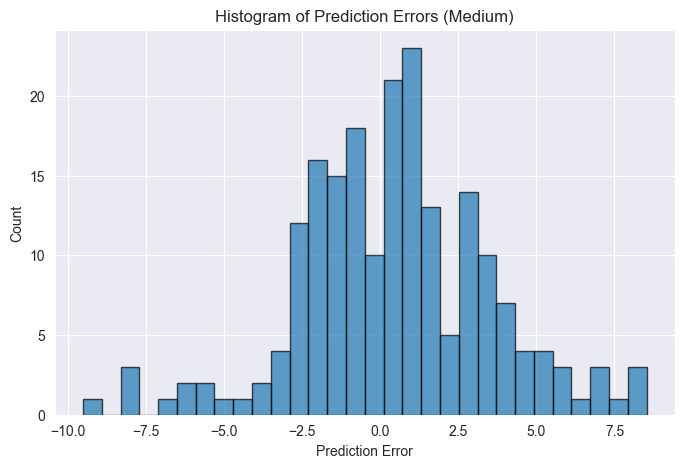

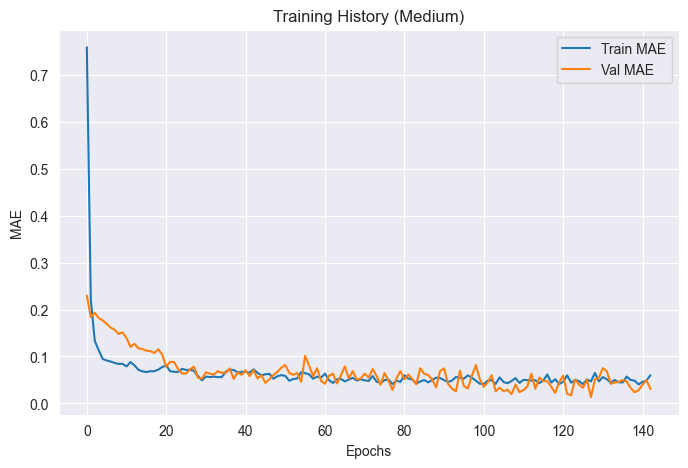

In [179]:
title='Medium'
mae = mean_absolute_error(Y_actual, Y_pred)
mse = mean_squared_error(Y_actual, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_actual, Y_pred)
wynikowa.loc[len(wynikowa)]=[title,mae,mse,rmse,r2]
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2: {r2:.3f}")
plt.figure(figsize=(8,5))
plt.scatter(range(len(Y_actual)), Y_actual, label="Actual", alpha=0.6)
plt.scatter(range(len(Y_pred)), Y_pred, label="Prediction", alpha=0.6)
plt.xlabel("Samples")
plt.ylabel("Unit Price")
plt.title("Prediction vs Actual (Medium)")
plt.legend()
plt.show()

errors = Y_actual - Y_pred
plt.figure(figsize=(8,5))
plt.hist(errors, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.title("Histogram of Prediction Errors (Medium)")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Training History (Medium)")
plt.legend()
plt.show()

In [180]:
def build_deep_model(input_dim):
    model = Sequential()

    model.add(layers.Dense(128, activation='relu', input_shape=(input_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.25))

    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.25))

    model.add(layers.Dense(1, activation='linear'))

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

deep_model = build_deep_model(input_dim)
history_deep = deep_model.fit(
    X_train_scaled, Y_train_scaled,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    # callbacks=[es_m]
)

C:\Users\Lenovo\PycharmProjects\ssi\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 2.4660 - mae: 1.2215 - val_loss: 0.2118 - val_mae: 0.4071
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6319 - mae: 1.0217 - val_loss: 0.1162 - val_mae: 0.3003
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2373 - mae: 0.8822 - val_loss: 0.0871 - val_mae: 0.2612
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9353 - mae: 0.7680 - val_loss: 0.0723 - val_mae: 0.2354
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8036 - mae: 0.7092 - val_loss: 0.0678 - val_mae: 0.2227
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7700 - mae: 0.6945 - val_loss: 0.0671 - val_mae: 0.2193
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6432 - mae: 0.6343 - val_loss: 0.0687 - val_mae: 0.2267
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5489 - mae: 0.5708 - val_loss: 0.0648 - val_mae: 0.2130
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.56

In [182]:
Y_pred_scaled = deep_model.predict(X_test_scaled).flatten()
Y_pred = np.expm1(scaler_Y.inverse_transform(Y_pred_scaled.reshape(-1,1))).flatten()
Y_actual = np.expm1(scaler_Y.inverse_transform(Y_test_scaled.reshape(-1,1))).flatten()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


MAE: 4.404
MSE: 37.325
RMSE: 6.109
R2: 0.950


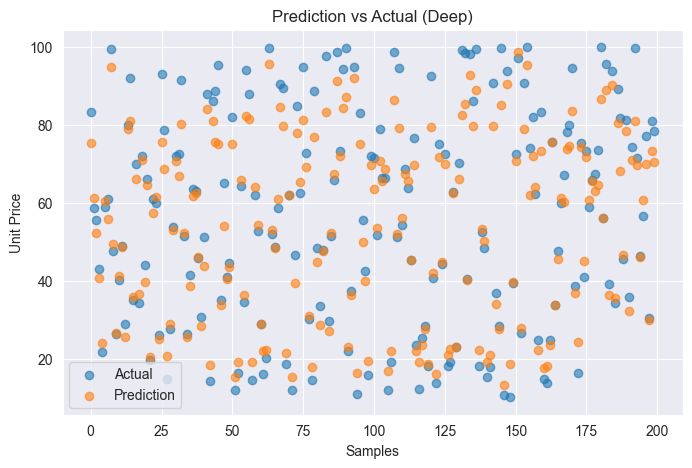

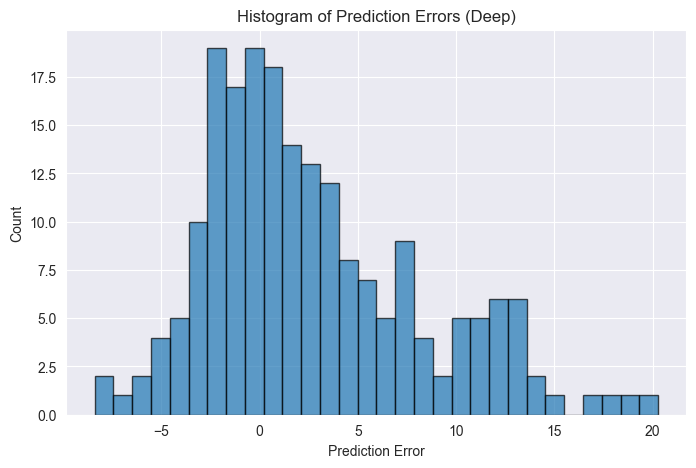

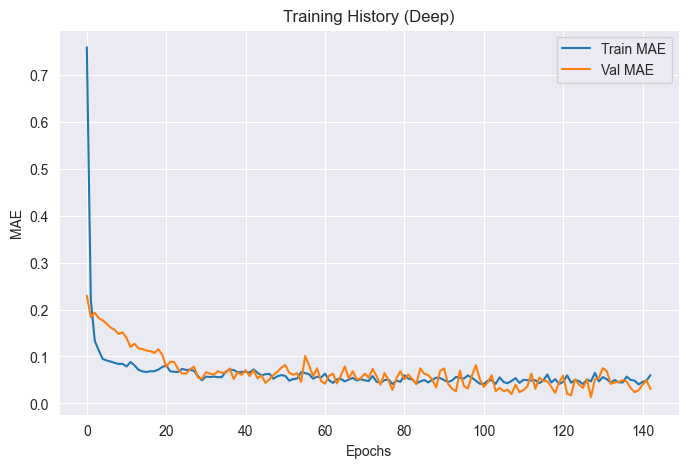

In [183]:
title = 'Deep'
mae = mean_absolute_error(Y_actual, Y_pred)
mse = mean_squared_error(Y_actual, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_actual, Y_pred)
wynikowa.loc[len(wynikowa)]=[title,mae,mse,rmse,r2]
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2: {r2:.3f}")
plt.figure(figsize=(8,5))
plt.scatter(range(len(Y_actual)), Y_actual, label="Actual", alpha=0.6)
plt.scatter(range(len(Y_pred)), Y_pred, label="Prediction", alpha=0.6)
plt.xlabel("Samples")
plt.ylabel("Unit Price")
plt.title("Prediction vs Actual (Deep)")
plt.legend()
plt.show()

errors = Y_actual - Y_pred
plt.figure(figsize=(8,5))
plt.hist(errors, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.title("Histogram of Prediction Errors (Deep)")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Training History (Deep)")
plt.legend()
plt.show()

In [190]:
wynikowa

,title,MAE,MSE,RMSE,R2
0,Bayesian parameters,1.341498,2.866250,1.693000,0.996155
1,Simple,1.627392,4.895031,2.212472,0.993434
2,Medium,2.373275,9.665646,3.108962,0.987035
3,Deep,4.403719,37.325145,6.109431,0.949934
4,Bayesian parameters,1.541951,3.877696,1.969187,0.994799


In [149]:
def build_model_tuner(hp):
    model = Sequential()
    for i in range(hp.Int("num_layers", 3, 5)):
        model.add(layers.Dense(
            units=hp.Int("units_" + str(i), 16, 128, step=16),
            activation='relu'
        ))
        model.add(layers.Dropout(hp.Float("dropout_" + str(i), 0.0, 0.5, step=0.1)))
    model.add(layers.Dense(1, activation='linear'))

    lr = hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='mse', metrics=['mae'])
    return model

In [153]:
tuner = kt.BayesianOptimization(
    hypermodel=build_model_tuner,
    objective='val_mae',
    max_trials=20,
    directory='tuner_dir',
    project_name='supermarket_price4'
)

In [154]:
tuner.search(
    X_train_scaled,
    Y_train_scaled,
    validation_split=0.2,
    epochs=50,
    callbacks=[EarlyStopping(patience=5)]
)

Trial 20 Complete [00h 00m 13s]
val_mae: 0.07837994396686554

Best val_mae So Far: 0.02880401350557804
Total elapsed time: 00h 03m 30s


In [155]:
best_model_nowy = tuner.get_best_models(1)[0]
best_hp_nowy = tuner.get_best_hyperparameters(1)[0]
print(best_hp_nowy.values)

{'num_layers': 3, 'units_0': 64, 'dropout_0': 0.0, 'units_1': 96, 'dropout_1': 0.1, 'units_2': 96, 'dropout_2': 0.1, 'learning_rate': 0.001, 'units_3': 128, 'dropout_3': 0.1, 'units_4': 128, 'dropout_4': 0.1}


C:\Users\Lenovo\PycharmProjects\ssi\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
